# Automatic Ticket Classification
<hr style="border:0.2px solid gray"> </hr>

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. we can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Importing Libraries

In [68]:
pip install swifter

In [69]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [70]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import NMF

from pprint import pprint

from wordcloud import WordCloud
pd.set_option('max_colwidth', 800)

import warnings
warnings.filterwarnings('ignore')

In [71]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [72]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
100% 83.4M/83.4M [00:00<00:00, 205MB/s]


In [73]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading Data

In [74]:
# Opening JSON file
a = open('//content//complaints-2021-05-14_08_16.json')

In [75]:
data = json.load(a)
# returns JSON object as a dictionary
df_1 = pd.json_normalize(data)

## Data Preparation

In [76]:
# Inspect the dataframe to understand the given data.
df_1.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [77]:
#print the column names
df_1.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [78]:
#Assign new column names
df_1.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [79]:
df_1.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [80]:
df_1 = df_1[['complaints_what_happened', 'tag']]

In [81]:
df_1 = df_1[df_1['complaints_what_happened'].astype(bool)]
df_1

,complaints_what_happened,tag
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports"
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the tick...","Credit reporting, credit repair services, or other personal consumer reports"
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Checking or savings account
...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school textbooks for my XXXX year old daughter because she transferred to a new school. All three books were damaged when a water bottle in her backpack broke. The Chase representative assured me the textbooks would be covered and instructed me to file a claim at XXXX. I immediately went to the website and filed the claim, including uploading all of the requested paperwork which included a copy of my credit card statement, copies of the three receip

## Prepare the text for topic modeling

After removing blank complaints:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


After all the cleaning operations, performed the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [82]:
# Clean the text and remove unnecessary elements
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [83]:
df_1['complaints'] = df_1['complaints_what_happened'].apply(clean_data)
df_1.head()

,complaints_what_happened,tag,complaints
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the tick...","Credit reporting, credit repair services, or other personal consumer reports",on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she eplained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then eplicitly told her i was glad i got denied an...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account n

In [84]:
# Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [85]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_cleans = pd.DataFrame({'complaints':df_1['complaints'], 'lemmatized':df_1['complaints'].apply(lemmatization)})

In [86]:
df_cleans.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not etend credit without verifying the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she eplained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then eplicitly told her i was glad i got denied an...,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted and wa referred to chase bank i then immediately contacted chase bank within no more than minute of getting the notification on the screen and i wa told by the chase representative i spoke with that my application wa denied but she could not state why i asked for more information about the offer and she eplained that even if i had been approved the credit offer only get applied after the first account statement and could not be used to purchase the ticket i then eplicitly told her i wa glad i got denied and i wa abs...
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,my grand son give me check for i depo

In [87]:
# Extract the POS tags

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_cleans["complaint_POS_removed"] =  df_cleans.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

## Exploratory data analysis to get familiar with the data.

Data visulaisation:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




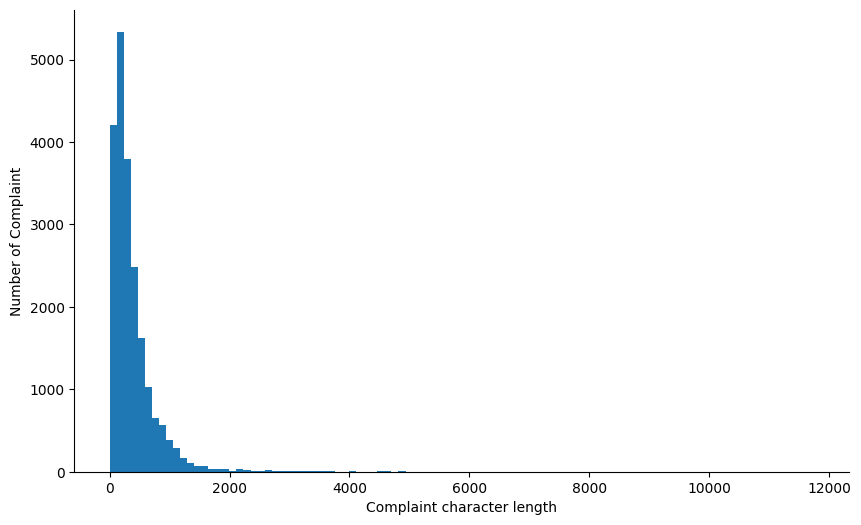

In [88]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_cleans.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency in articles after processing the text.

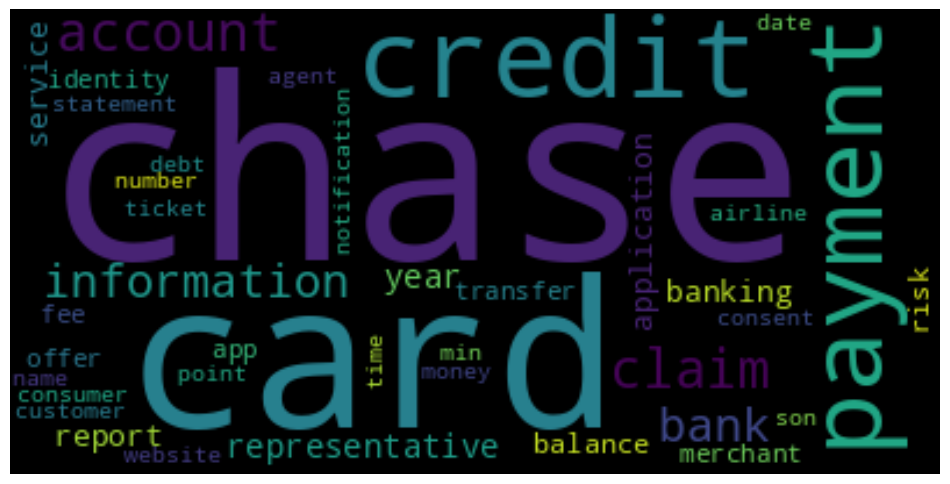

In [89]:
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_cleans['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [90]:
df_cleans['Complaint_clean'] = df_cleans['complaint_POS_removed'].str.replace('-PRON-', '')
df_cleans

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not etend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she eplained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then eplicitly told her i was glad i got denied an...,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted and wa referred to chase bank i then immediately contacted chase bank within no more than minute of getting the notification on the screen and i wa told by the chase representative i spoke with that my application wa denied but she could not state why i asked for more information about the offer and she eplained that even if i had been approved the cre

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [91]:
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_cleans['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram

In [92]:
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


In [93]:
df_bigram = top_grams(2)
df_bigram.head(10)

,frequency,unigram
0,12734,chase bank
1,10941,credit card
2,3709,called chase
3,3569,checking account
4,3253,credit report
5,3021,customer service
6,2714,jp morgan
7,2567,morgan chase
8,2534,chase credit
9,1997,account chase


In [94]:
df_trigram = top_grams(3)
df_trigram.head(10)

,frequency,unigram
0,2230,jp morgan chase
1,1982,chase credit card
2,773,credit card company
3,692,morgan chase bank
4,666,credit card account
5,560,chase customer service
6,554,account chase bank
7,552,credit card chase
8,457,received letter chase
9,438,called chase bank


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [95]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [96]:

dtm = tfidf.fit_transform(df_cleans['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we will perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [97]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [98]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [99]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

14985

In [100]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [101]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [102]:


df_cleans['Topic'] = topic_results.argmax(axis=1)

In [103]:
# Print the first 5 Complaint for each of the Topics
First5_comp=df_cleans.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,0
21,on i made a payment to an online retailer using chase quick pay with on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank i contacted chase via a secured message on eplaining what happened and asked is there a way to reverse this transaction or do you have a contact at that can give me more information about the recipient that my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the epertise of an...,on i made a payment to an online retailer using chase quick pay with on the chase website i realized that this wa a scam website after no confirmation product or response to any inquiry regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailer bank i contacted chase via a secured message on eplaining what happened and asked is there a way to reverse this transaction or do you have a contact at that can give me more information about the recipient that my message wa reviewed and i received a response restating my original email and informing me that the transfer ha been completed however a you mentioned that the website is a scam while we can handle most inquiry by email some require the epertise of another tea...,payment retailer chase pay chase website scam website confirmation product response inquiry order chase information transaction refund retailer bank chase message way transaction contact information recipient message response email transfer website scam inquiry email epertise team order regard refund consumer support team number email situation claim department transaction chase information transfer agent call closing script contact number opportunity information question word phrase information system bank bank app transaction menu customer service agent information transaction system bank app transaction line everything understanding situation call chase chase time agent information bank information information situation claim department information nothing nature transaction type tr...,payment retailer chase pay chase website scam website confirmation product response inquiry order chase information transaction refund retailer bank chase message way transaction contact information recipient message response email transfer website scam inquiry email epertise team order regard refund consumer support team number email situation claim department transaction chase information transfer agent call closing script contact number opportunity information question word phrase information system bank bank app transaction menu customer service agent information transaction system bank app transaction line everything understanding situation call chase chase time agent information bank information information situation c

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [104]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_cleans['Topic'] = df_cleans['Topic'].map(Topic_names)

## Supervised model to predict any new complaints to the relevant Topics.

We have built a model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

*Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)*

In [105]:


Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_cleans['Topic'] = df_cleans['Topic'].map(Topic_names)

In [106]:

training_data = df_cleans.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

#### Applying the supervised models on the training data created. In this process, we are going to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [107]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [109]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

**1. Logistic Regression**

In [110]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       944
           1       0.96      0.95      0.96       914
           2       0.98      0.95      0.96       714
           3       0.94      0.98      0.96      1123
           4       0.97      0.90      0.93       520

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



**2. Decision Tree**

In [111]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       944
           1       0.80      0.79      0.79       914
           2       0.79      0.81      0.80       714
           3       0.80      0.80      0.80      1123
           4       0.70      0.69      0.70       520

    accuracy                           0.77      4215
   macro avg       0.76      0.76      0.76      4215
weighted avg       0.77      0.77      0.77      4215



**3. Random Forest Classifier**

In [112]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       944
           1       0.77      0.77      0.77       914
           2       0.87      0.79      0.83       714
           3       0.60      0.98      0.75      1123
           4       0.98      0.12      0.22       520

    accuracy                           0.72      4215
   macro avg       0.81      0.66      0.66      4215
weighted avg       0.78      0.72      0.70      4215



**4. Gaussian Naive Bayes**

In [113]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.48      0.35      0.40       944
           1       0.35      0.27      0.30       914
           2       0.52      0.50      0.51       714
           3       0.46      0.30      0.37      1123
           4       0.18      0.51      0.27       520

    accuracy                           0.36      4215
   macro avg       0.40      0.38      0.37      4215
weighted avg       0.42      0.36      0.37      4215



**Clearly Logistic Regression is performing better**

### Infering the best model

In [114]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [115]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [116]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Others
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Credit card or prepaid card
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Account Services
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and their locations in the city of Dubai,Credit card or prepaid card


## Conclusion
    
* **As expected 5 topics were indetified namely:**
    1. Account Services
    2. Others
    3. Mortgage/Loan
    4. Credit card or prepaid card
    
    
* **Tried 4 models on the data with accuracies as follows:**

    | Model       | Accuracy |
    | ----------- | ----------- |
    | Logistic Regression      | 0.95       |
    | Decision Tree   | 0.77        |
    | Random Forest      | 0.77       |
    | Naive Bayes   | 0.42        |
    
 <br /> <br /> <br /> <br /><br /> <br /><br />
* **Logistic Regression has highest accuracy of `0.95`, Hence is a good fit for this particular case study.**